In [56]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH = os.path.realpath("../data/WESAD")

In [3]:
class Subject:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

In [4]:
s10 = Subject(DATA_PATH, '10')
s10_wrist_data = s10.get_wrist_data()
bvp_signal = s10_wrist_data['BVP'][:,0]
eda_signal = s10_wrist_data['EDA'][:,0]
acc_x_signal = s10_wrist_data['ACC'][:,0]
acc_y_signal = s10_wrist_data['ACC'][:,1]
acc_z_signal = s10_wrist_data['ACC'][:,2]
temp_signal = s10_wrist_data['TEMP'][:,0]
labels = s10.labels

In [11]:
# Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))


In [20]:
label_df = pd.DataFrame(s10.labels, columns=['label'])
label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
label_df.index = pd.to_datetime(label_df.index, unit='s')

In [23]:
data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
df.index = pd.to_datetime(df.index, unit='s')
df = df.join(label_df)
df['label'] = df['label'].fillna(method='ffill')
df.reset_index(drop=True, inplace=True)


##### Anwendung von Fourier Transformation (scipy.fft) am Beispiel: https://realpython.com/python-scipy-fft/
Wichtige Parameter:
1. **SAMPLE_RATE** (in Hertz) determines how many data points the signal uses to represent the sine wave per second. So if the signal had a sample rate of 10 Hz and was a five-second sine wave, then it would have 10 * 5 = 50 data points.
2. **DURATION** (in Seconds) is the length of the generated sample. -> Frage hierzu: können wir überhaupt duration in seconds nehmen, wenn wir gar nicht mit den Zeitstempeln arbeiten, oder ist das irrelvant?

Für *fftfreq* wird N (= SAMPLE_RATE * DURATION) und 1/SAMPLE_RATE

### Window

In [86]:
window_len = 64 * 60 # fs = 64 and window length in seconds = 60
subwindow_len = 64 * 30 # fs = 64 and sub-window length in seconds = 30
window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25

window = df[:window_len]
subwindows = []

for i in range(0, window_len, window_shift):
    print(i)
    if i+subwindow_len <= window_len:

        subwindow = df[i:i+subwindow_len]
        subwindows.append(subwindow)
        print(subwindow)

0
        BVP       EDA       ACC_x       ACC_y         ACC_z       TEMP  label
0     10.17  0.349215  107.000000 -105.000000  1.270000e+02  33.130000    0.0
1     12.04  0.325576  102.356872 -113.012765  1.126363e+02  33.223713    0.0
2     13.01  0.305809   67.000000  -52.000000  4.500000e+01  33.302211    0.0
3     13.07  0.289995   32.736815   17.606782 -5.830147e+00  33.365191    0.0
4     12.33  0.278123   26.000000   40.000000 -3.202097e-14  33.412692    0.0
...     ...       ...         ...         ...           ...        ...    ...
1915   5.47  0.358221   14.513470  -75.934280  1.440351e+01  33.155813    0.0
1916   6.91  0.358469   13.000000  -73.000000  1.400000e+01  33.156445    0.0
1917   7.69  0.358720   12.394525  -69.947345  1.378235e+01  33.157210    0.0
1918   7.81  0.358969   12.000000  -67.000000  1.300000e+01  33.158080    0.0
1919   7.34  0.359214   11.060886  -62.381661  1.114435e+01  33.159022    0.0

[1920 rows x 7 columns]
16
        BVP       EDA       ACC_x 

0
       BVP       EDA       ACC_x       ACC_y         ACC_z       TEMP  label
0    10.17  0.349215  107.000000 -105.000000  1.270000e+02  33.130000    0.0
1    12.04  0.325576  102.356872 -113.012765  1.126363e+02  33.223713    0.0
2    13.01  0.305809   67.000000  -52.000000  4.500000e+01  33.302211    0.0
3    13.07  0.289995   32.736815   17.606782 -5.830147e+00  33.365191    0.0
4    12.33  0.278123   26.000000   40.000000 -3.202097e-14  33.412692    0.0
..     ...       ...         ...         ...           ...        ...    ...
443 -95.33  0.343879   16.015270  -58.014264  1.432545e+01  33.117342    0.0
444 -94.04  0.343758   16.000000  -58.000000  1.400000e+01  33.119272    0.0
445 -93.85  0.343583   16.085786  -58.365212  1.370724e+01  33.121600    0.0
446 -94.39  0.343360   16.000000  -59.000000  1.400000e+01  33.124233    0.0
447 -95.18  0.343102   15.812592  -59.249986  1.425438e+01  33.127070    0.0

[448 rows x 7 columns]


ValueError: could not broadcast input array from shape (448,) into shape (1920,)

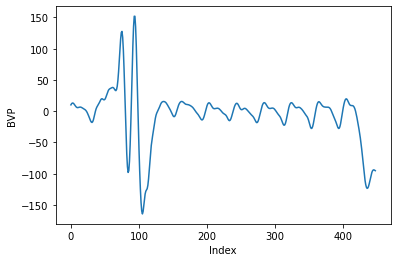

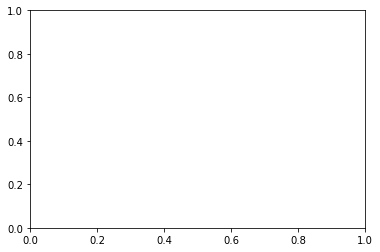

In [80]:
window_len = 64 * 60 # fs = 64 and window length in seconds = 60
subwindow_len = 64 * 7 # fs = 64 and sub-window length in seconds = 30
window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25

window = df[:window_len]
subwindows = []

for i in range(0, window_len, window_shift):
    print(i)
    if i+subwindow_len <= window_len:

        subwindow = df[i:i+subwindow_len]
        subwindows.append(subwindow)
        print(subwindow)

        x = subwindow.index
        y = np.array(subwindow['BVP'])
        plt.plot(x, y)
        plt.xlabel('Index')
        plt.ylabel('BVP')
        # y = scipy.fft(subwindow['BVP'].to_numpy())
        # freq = fft.fftfreq(8, 0.125)
        f_s = 30
        f_s = 64
        # du hattest hier x drin - das ist nur ein RangeIndex, der Input für fft ist aber ein Array, deswegen dachte ich vielleicht eher y
        X = scipy.fft.fft(y)
        #freqs = scipy.fft.fftfreq(len(x)) * f_s
        N = 64 * 30
        freqs = scipy.fft.fftfreq(N, 1/f_s)
        fig, ax = plt.subplots()

        ax.stem(freqs, np.abs(X))
        ax.set_xlabel('Frequency in Hertz [Hz]')
        ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
        ax.set_xlim(-f_s / 2, f_s / 2)
        ax.set_ylim(-5, 110)
        FFT =scipy.fft.fft(y)
        new_N= len(FFT)//2
        f_nat=1
        new_X = np.linspace(10**-12, f_nat/2, new_N, endpoint=True)
        new_Xph=1.0/(new_X)
        FFT_abs=np.abs(FFT)
        plt.plot(new_Xph,2*FFT_abs[0:len(FFT)//2]/len(new_Xph),color='black')
        plt.xlabel('Period ($h$)',fontsize=20)
        plt.ylabel('Amplitude',fontsize=20)
        plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=20)
        plt.grid(True)
        plt.xlim(0,200)
        

(0.0, 64.0)

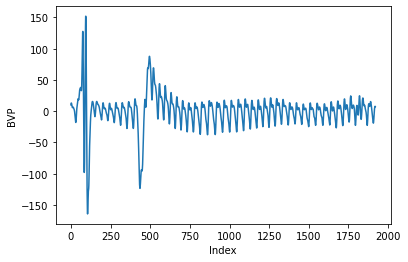

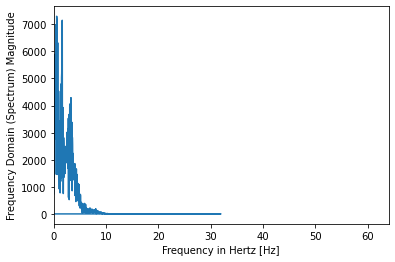

In [90]:
f_s = 64
duration = 30
subwindow = subwindows[0]
x = subwindow.index
y = np.array(subwindow['BVP'])
plt.plot(x, y)
plt.xlabel('Index')
plt.ylabel('BVP')
yf = scipy.fft.fft(y)
#freqs = scipy.fft.fftfreq(len(x)) * f_s
N = f_s * duration
freqs = scipy.fft.fftfreq(N, 1/f_s)
fig, ax = plt.subplots()

plt.plot(freqs, np.abs(yf))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 64)

In [128]:
freqs= []
yfs = []

In [ ]:
for subwindow in subwindows:
    f_s = 64
    duration = 30
    x = subwindow.index
    y = np.array(subwindow['BVP'])
    plt.plot(x, y)
    plt.xlabel('Index')
    plt.ylabel('BVP')
    yf = scipy.fft.fft(y)
    #freqs = scipy.fft.fftfreq(len(x)) * f_s
    N = f_s * duration
    freq = scipy.fft.fftfreq(N, 1/f_s)
    fig, ax = plt.subplots()
    freqs.append(freq)
    yfs.append(yf)
    plt.plot(freq, np.abs(yf))
    ax.set_xlabel('Frequency in Hertz [Hz]')
    ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax.set_xlim(0, 64)
    

In [137]:
yfs

[array([  740.26         -0.j        ,   503.87545585-1247.6207289j ,
        -1504.08463922+1905.27287459j, ...,  5035.1755933 -2907.26115471j,
        -1504.08463922-1905.27287459j,   503.87545585+1247.6207289j ]),
 array([  829.32         -0.j        ,   657.55046176-1218.96466475j,
        -1605.89989973+1738.76860612j, ...,  4607.53920835-3660.87642979j,
        -1605.89989973-1738.76860612j,   657.55046176+1218.96466475j]),
 array([  892.63         -0.j        ,   783.76153302-1183.37894546j,
        -1715.517226  +1560.3839274j , ...,  4041.49458818-4335.08561579j,
        -1715.517226  -1560.3839274j ,   783.76153302+1183.37894546j]),
 array([  873.44         -0.j        ,   825.29408076-1136.37957033j,
        -1888.96003496+1381.21877231j, ...,  3293.16298178-4926.96184919j,
        -1888.96003496-1381.21877231j,   825.29408076+1136.37957033j]),
 array([  121.13         -0.j        ,   131.57363562-1107.89665324j,
        -2774.31082481+1143.68605017j, ...,  1731.78362757-533

In [139]:
# mean the yfs for every position in the arrays creating a new array
yfs_mean = []





[  740.26         -0.j           503.87545585-1247.6207289j
 -1504.08463922+1905.27287459j ...  5035.1755933 -2907.26115471j
 -1504.08463922-1905.27287459j   503.87545585+1247.6207289j ]
[  829.32         -0.j           657.55046176-1218.96466475j
 -1605.89989973+1738.76860612j ...  4607.53920835-3660.87642979j
 -1605.89989973-1738.76860612j   657.55046176+1218.96466475j]
[  892.63         -0.j           783.76153302-1183.37894546j
 -1715.517226  +1560.3839274j  ...  4041.49458818-4335.08561579j
 -1715.517226  -1560.3839274j    783.76153302+1183.37894546j]
[  873.44         -0.j           825.29408076-1136.37957033j
 -1888.96003496+1381.21877231j ...  3293.16298178-4926.96184919j
 -1888.96003496-1381.21877231j   825.29408076+1136.37957033j]
[  121.13         -0.j           131.57363562-1107.89665324j
 -2774.31082481+1143.68605017j ...  1731.78362757-5332.73727848j
 -2774.31082481-1143.68605017j   131.57363562+1107.89665324j]
[-1132.2          -0.j         -1063.39617381-1132.45878918j


In [134]:
len(yfs[0])

1920

In [39]:
i = 0
df[window_len*i:window_len*(i+1)]

,BVP,EDA,ACC_x,ACC_y,ACC_z,TEMP,label
0,10.17,0.349215,107.000000,-105.000000,1.270000e+02,33.130000,0.0
1,12.04,0.325576,102.356872,-113.012765,1.126363e+02,33.223713,0.0
2,13.01,0.305809,67.000000,-52.000000,4.500000e+01,33.302211,0.0
3,13.07,0.289995,32.736815,17.606782,-5.830147e+00,33.365191,0.0
4,12.33,0.278123,26.000000,40.000000,-3.202097e-14,33.412692,0.0
...,...,...,...,...,...,...,...
3835,83.54,0.354472,57.742036,6.426635,2.550001e+01,33.211302,0.0
3836,78.94,0.354641,58.000000,6.000000,2.500000e+01,33.211310,0.0
3837,66.86,0.354843,57.925310,6.319837,2.445016e+01,33.211207,0.0
3838,49.67,0.355076,58.000000,7.000000,2.500000e+01,33.210968,0.0
